## COVID-19
### Exploring Corona Virus Publications with WeLearn.

Hey there! This is a notebook I used for doing curated page for WeLearn.

If you haven't, check out the [Map on WeLearn][exp-page].

This is an open source analysis, and available on GitHub.

All the data used for this analysis is available via [WeLearn API][api-url].


[api-url]: https://welearn.cri-paris.org/.meta/docs
[exp-page]: https://welearn.cri-paris.org/experiments/covid19

In [7]:
%config InlineBackend.figure_formats = ['png']

import requests
import pandas as pd
import numpy as np
import scipy as sci
import scipy.spatial
import scipy.linalg
import networkx as nx
import networkx.readwrite.json_graph

from urllib.parse import urlparse
from pprint import pprint

import plotly.graph_objects as plotly_go

In [8]:
COVID19_UUID = '8705149e0d3a449e9a70747df29ccea4'
API_BASE_URL = f'https://welearn.cri-paris.org/api/resources/user/{COVID19_UUID}?limit=500'

covid_resources = requests.get(API_BASE_URL).json()
resources = covid_resources['results']

print(f'n(Resources) = {len(resources)}\n')

pprint(resources[0])

n(Resources) = 204

{'concepts': [{'cuid': 'Q472338',
               'title_en': None,
               'title_fr': 'Chronologie de la science',
               'wikidata_id': 'Q472338'}],
 'created': '2020-03-05T14:58:00.762712+00:00',
 'lang': 'fr',
 'readability_score': 42.0,
 'resource_id': '1dd62fc5b16a4a658881b1e72e1a829b',
 'title': 'Collège de France',
 'updated': '2020-03-05T14:58:07.950642+00:00',
 'url': 'https://www.college-de-france.fr/site/college/index.htm'}


### Using NetworkX for Graph Statistics

The API gets us the resources in this format:

```json
{
  "results": [
    {
      "resource_id": "string",
      "title": "string",
      "url": "string",
      "lang": "string",
      "readability_score": 0,
      "concepts": [
        {
          "cuid": "string",
          "wikidata_id": "string",
          "title_en": "string",
          "title_fr": "string"
        }
      ]
    }
  ],
  "pagination": {
    "count": 0,
    "skip": 0,
    "limit": 0,
    "next": 0
  }
}
```

We can quite easily transform this to a `node-link` format object to get a `NetworkX` Graph.

The `node-link` format looks like this:
```json
{ nodes: [{id, ...props}], links: [{source, target}] }
```

In [3]:
def resource_graph(data):
  def links_gen():
    for resource in data:
      for concept in resource['concepts']:
        yield {
          'source': resource['resource_id'],
          'target': concept['wikidata_id'],
        }

  def nodes_gen():
    '''Here we're sequentially emitting the resource and concept nodes.
       It should be noted that this is a flat list so we add the "group"
       properties as well.
       Group 1: Resource, Group 2: Concept.

       For concept nodes, we'd like to avoid duplicating data. We'll use
       a list to keep track of the concepts already emitted.
    '''
    _cemit = []
    for resource in data:
      yield {
        'id': resource['resource_id'],
        'group': 1,
        'url': resource['url'],
        'title': resource['title'],
      }
      for concept in resource['concepts']:
        if concept['wikidata_id'] in _cemit:
          continue

        _cemit.append(concept['wikidata_id'])
        yield {
          'id': concept['wikidata_id'],
          'group': 2,
          'title_en': concept['title_en'],
          'title_fr': concept['title_fr'],
        }

  node_links = {
    'nodes': list(nodes_gen()),
    'links': list(links_gen()),
  }
  graph = networkx.json_graph.node_link_graph(node_links)
  
  return (graph, node_links)


G, node_link_graph = resource_graph(resources)

# Network

Let us visualise a network...

Nice! We now have the node-link format object. Lets get some stats out of this:

visualise network


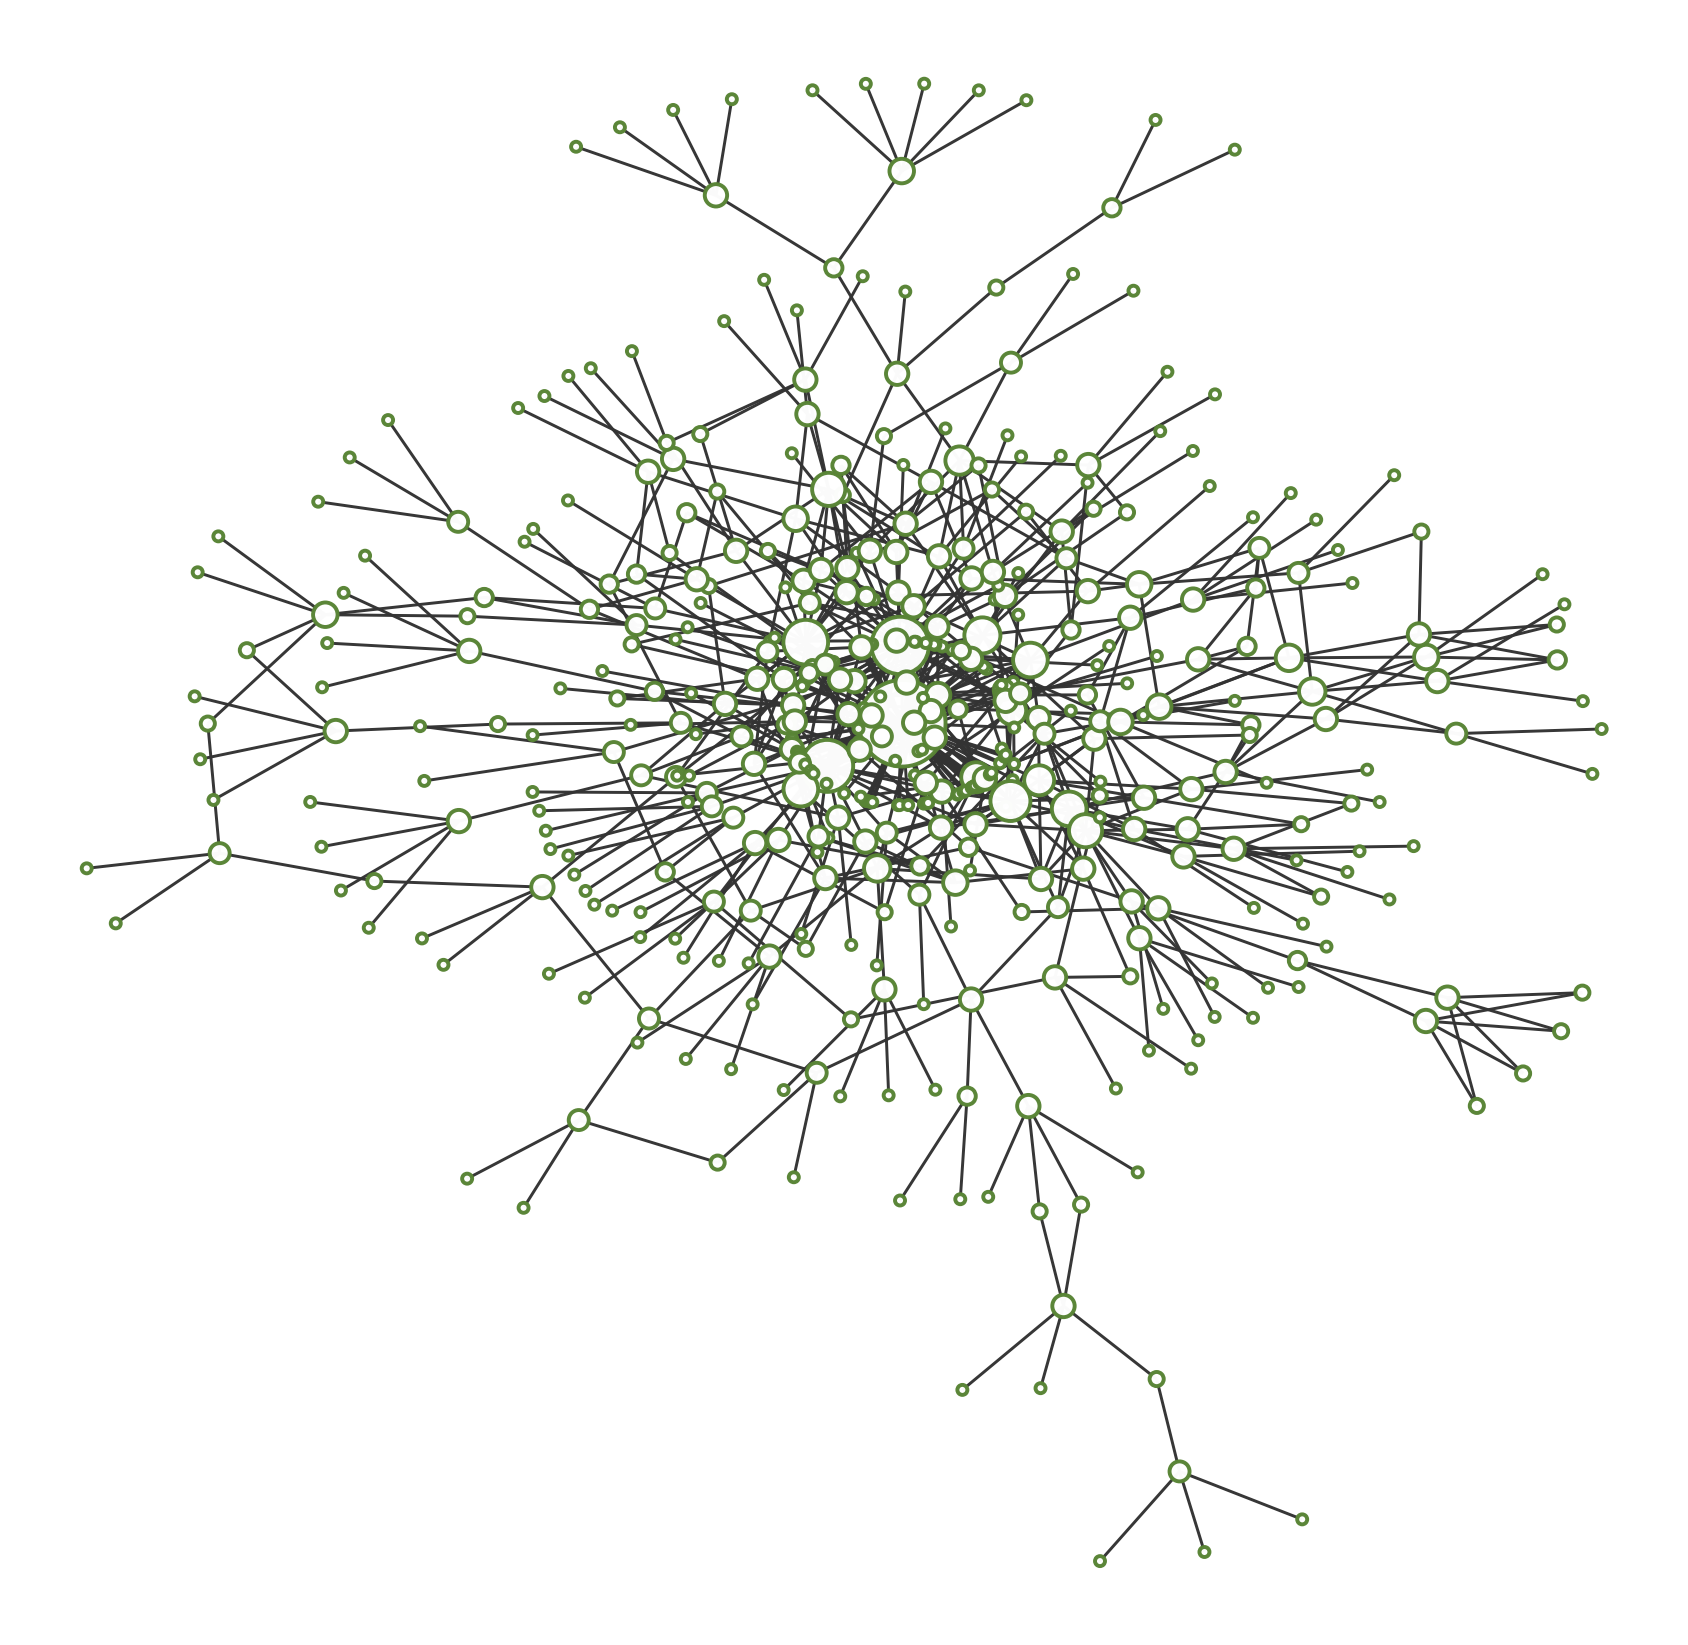

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

########## plot setup ############

ns = 175 # node size##############
cols = ["#c77739","#9765ca","#40a0e2","#c95980","#01bb96"]
cols = ["#927134","#9765ca","#40a0e2","#c95980","#01bb96"]
cols = ["#666666","#666666","#666666","#666666","#666666"]
cols = ["#b03e61","#aa592a","#588435","#6172cc","#814192"]

##################################


print('visualise network')

fig, ax = plt.subplots(figsize=(40, 40))
#G12 = nx.erdos_renyi_graph(40, .09)
plt.axis('off')
pos12 = nx.kamada_kawai_layout(G)

deg = dict(G.degree)
#nx.draw(G, pos12, node_size = [v * 500 for v in deg.values()], with_labels=False)#True


nx.draw_networkx_nodes(G, pos12, node_color='white', 
                       node_size=[v * 100 for v in deg.values()], linewidths=3.9,
                       alpha=0.98).set_edgecolor(cols[2])
nx.draw_networkx_edges(G, pos12, edge_color="#333333",
                       width=2.95, alpha=0.98)


#nx.draw(G)


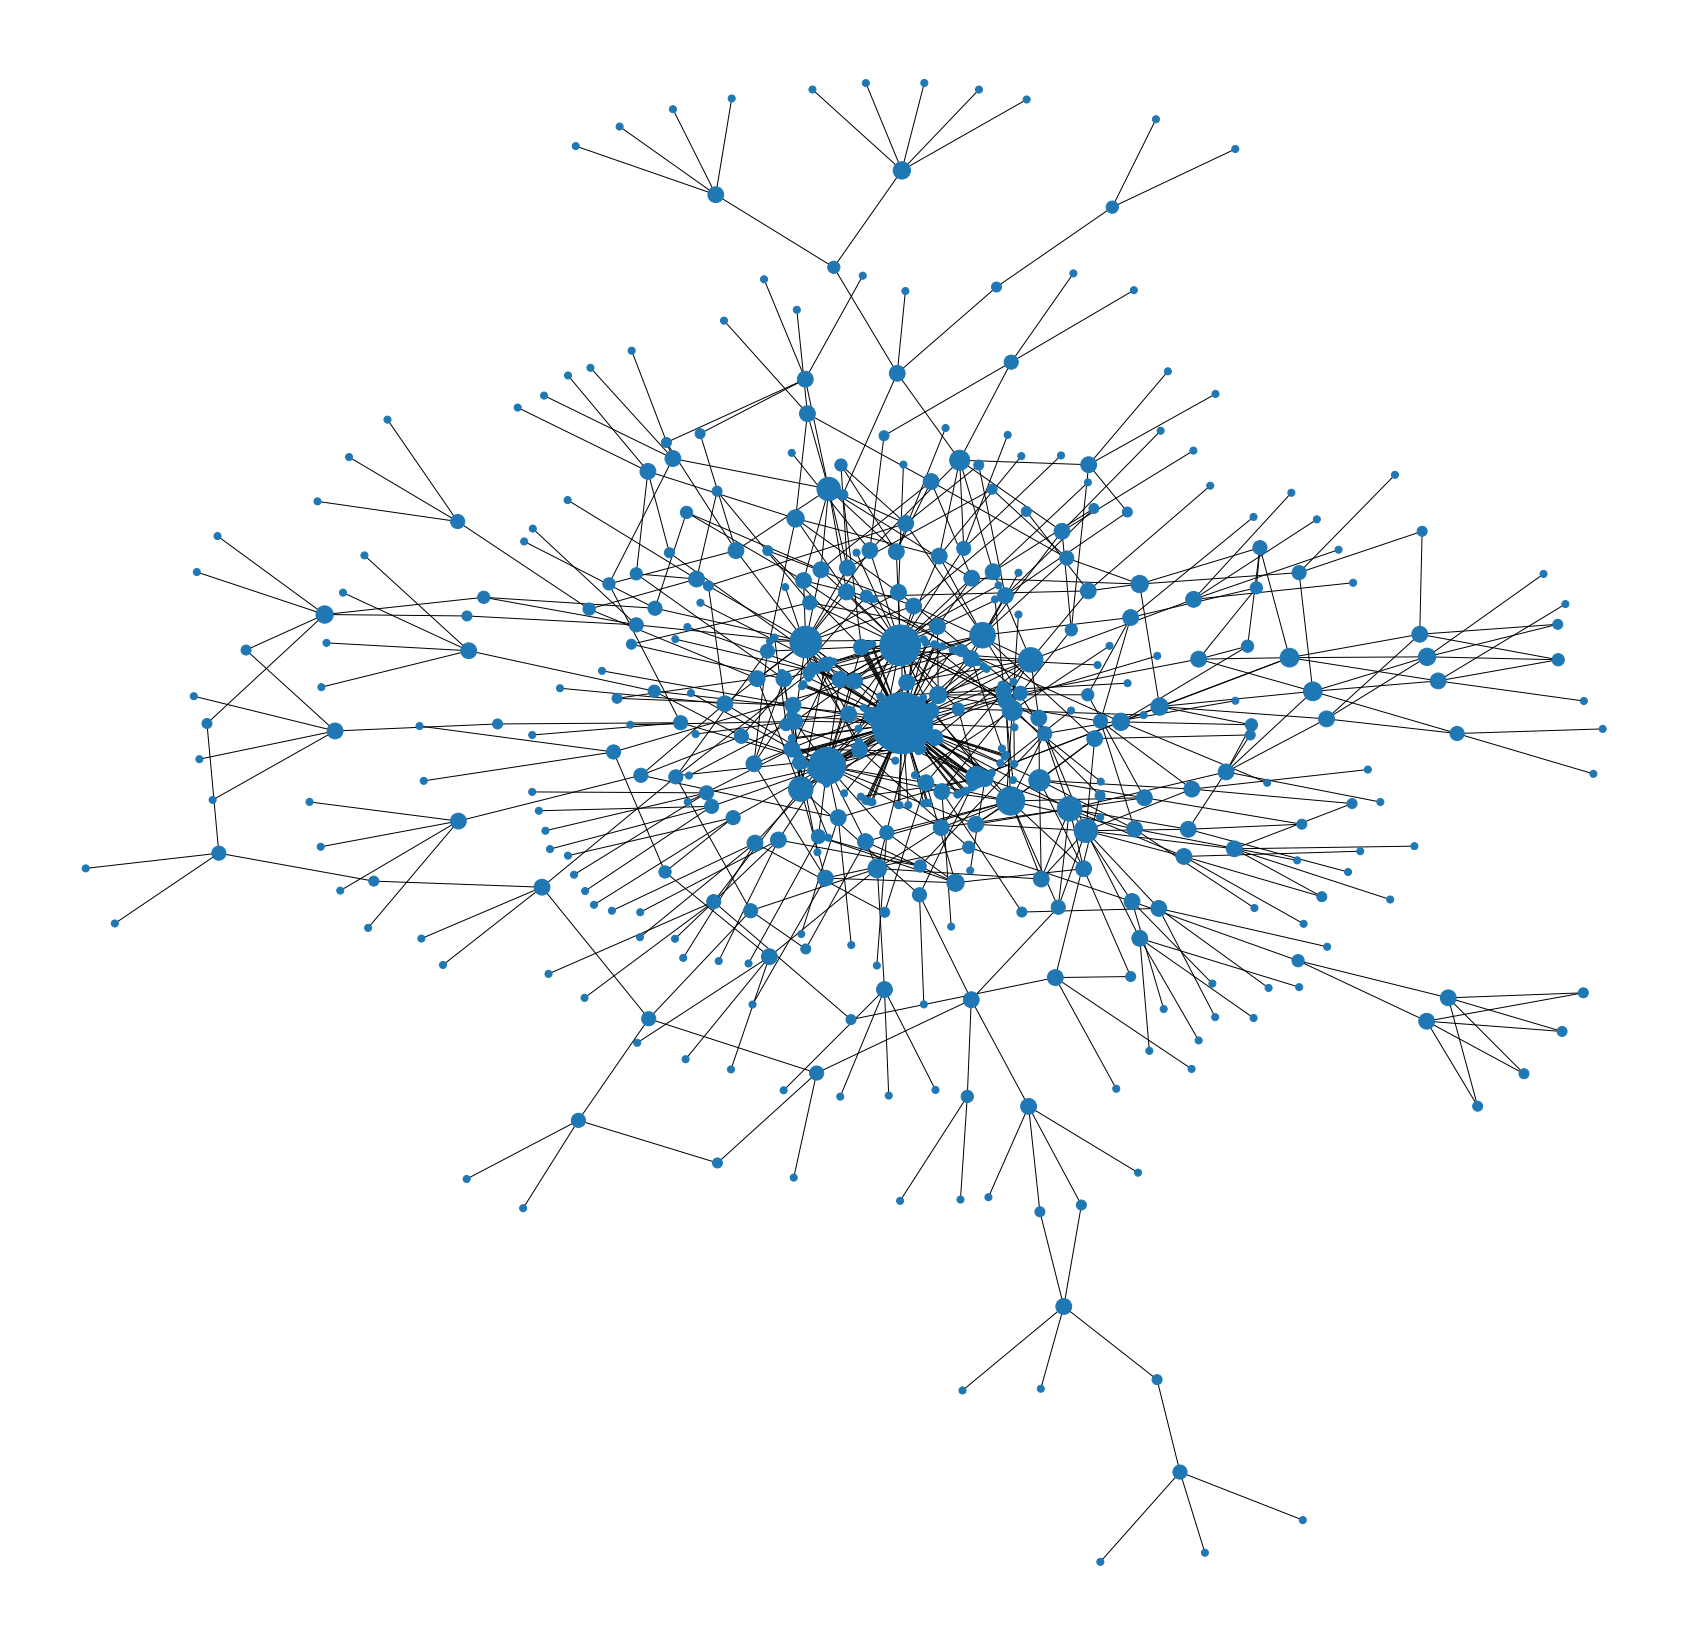

In [21]:
# let us try to visualise graph with additional properties e.g. degree, pagerank of pages

fig, ax = plt.subplots(figsize=(30, 30))
deg = dict(G.degree)
nx.draw(G, pos12, node_size = [v * 50 for v in deg.values()], with_labels=False)#True


Let us check whether there is any particular scale free property of a network.
Idea here is that in scale-free small-world networks information spreading is faster than in gridded networks (with the same amount of nodes).


Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.131473400173453
5.0


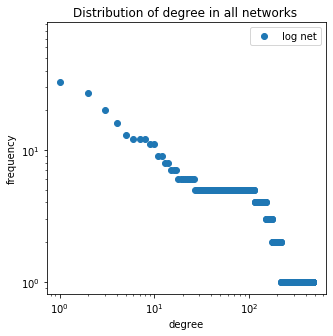

In [25]:
# scale-free network estimation

import powerlaw 

threshold =0.5

fig, ax = plt.subplots(figsize=(5, 5))

degree_sequence = sorted([d for n, d in G.degree()], reverse=True) # gives array of degree values
plt.title('Distribution of degree in all networks ')#+str(ind))
ax.set_xscale('log')
ax.set_yscale('log')

data = degree_sequence #array([1.7, 3.2, ]) # data can be list or numpy array
results = powerlaw.Fit(data)
print(results.power_law.alpha)
print(results.power_law.xmin)
R, p = results.distribution_compare('power_law', 'lognormal')
    
# plotting    
plt.plot(degree_sequence, 'o')
    
ax.legend(['log net'])
#xarray = np.arange(0,n)
#plt.plot(xarray**R, '--') # power law
plt.xlabel("degree")
plt.ylabel("frequency")
    
plt.show()


In [4]:
_nedge, _nnode = G.number_of_edges(), G.number_of_nodes()

print(f'n(edges) = {_nedge}')
print(f'n(nodes) = {_nnode}')


n(edges) = 680
n(nodes) = 481


**What are websites that are referred most often?**

In [5]:
# Use urllib to parse the urls and get the domain names in a set.
# with this, make a dataframe with <domain, freq> ordered pairs.

domains = [urlparse(r['url']).netloc for r in resources]
freq_list = [(x, domains.count(x)) for x in set(domains)]
domain_freq = (pd
               .DataFrame(freq_list, columns=['domain', 'freq'])
               .sort_values(by='freq', ascending=False))

In [9]:
fig = plotly_go.Figure(data=plotly_go.Bar(x=domain_freq.domain, y=domain_freq.freq))
fig.show()